In [1]:
import pandas as pd
import numpy as np
raw_df = pd.read_pickle('cifar10-resnet34.pkl')

In [2]:
base_cols = raw_df[['idx', 'batch_size', 'linear_lr', 'learning_rate', 'seed']]
from pandas.io.json import json_normalize
diagnostics = []
for diagnostic in ['train', 'test']:
    json_expanded = json_normalize(
        raw_df[diagnostic].tolist()).add_prefix(diagnostic + '_')
    for col in json_expanded.columns:
        json_expanded[col] = json_expanded[col].apply(lambda xs: np.array(xs))
    diagnostics.append(json_expanded)
df = base_cols.join(diagnostics)
df.head()

,idx,batch_size,linear_lr,learning_rate,seed,train_accuracy,train_loss,test_accuracy,test_loss
0,"[1, 390, 780, 1170, 1560, 1950, 2340, 2730, 31...",512,False,0.1,1,"[10.0, 66.934, 77.88, 80.082, 81.782, 88.588, ...","[2.3029256478881837, 0.9285806554794311, 0.645...","[10.0, 66.85, 76.82, 76.37, 78.26, 84.12, 86.6...","[2.302943173980713, 0.9723038528442383, 0.7237..."
1,"[1, 390, 780, 1170, 1560, 1950, 2340, 2730, 31...",512,False,0.1,2,"[10.0, 69.864, 75.922, 86.86, 85.96, 90.408, 9...","[2.3029330667114256, 0.8403456113243103, 0.699...","[10.0, 69.36, 73.5, 83.25, 81.7, 84.64, 86.98,...","[2.3029310199737547, 0.8659416593551635, 0.832..."
2,"[1, 24, 48, 72, 96, 120, 144, 168, 192, 216, 2...",8192,True,0.1,1,"[10.25, 11.816, 10.588, 12.376, 10.0, 10.282, ...","[2.305327310581207, 2.2947557479000094, 2.4995...","[10.37, 12.27, 10.59, 12.67, 10.0, 10.38, 10.0...","[2.305295885658264, 2.286732203578949, 2.55957..."
3,"[1, 24, 48, 72, 96, 120, 144, 168, 192, 216, 2...",8192,True,0.1,2,"[10.0, 10.642, 10.754, 10.436, 10.016, 10.288,...","[2.306543853111267, 2.641214992442131, 2.41652...","[10.0, 10.74, 10.95, 10.84, 10.02, 10.24, 9.5,...","[2.3064719670772553, 2.6884401956796644, 2.433..."
4,"[1, 97, 194, 291, 388, 485, 582, 679, 776, 873...",2048,False,0.1,1,"[10.0, 34.596, 46.6, 68.396, 74.596, 77.83, 78...","[2.303390376148224, 1.968656120824814, 1.56740...","[10.0, 35.72, 46.89, 67.54, 72.67, 75.6, 75.51...","[2.303411853027344, 1.986387162399292, 1.60577..."


In [3]:
diagnostics_cols = [col for d in diagnostics for col in d.columns]
diagnostics_cols

['train_accuracy', 'train_loss', 'test_accuracy', 'test_loss']

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def ma(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    s = n - 1
    ret[s:] /= n
    ret[:s] /= np.arange(s) + 1
    return ret

lr = 0.1
def simple_df(linear_lr):
    simple = df.loc[(df['linear_lr'] == linear_lr) & (df['learning_rate'] == lr)]
    key_cols = ['linear_lr', 'batch_size', 'learning_rate']
    assert set(simple.columns) == set(diagnostics_cols + key_cols + ['seed', 'idx'])
    # avg over seeds
    agg_dict = {diagnostic_col: lambda x: list(np.mean(np.array(x.values), axis=0))
                for diagnostic_col in diagnostics_cols}
    def check_unique_first(series_of_ndarray):
        u = set(map(tuple, series_of_ndarray))
        assert len(u) == 1
        return list(next(iter(u)))
    agg_dict['idx'] = check_unique_first
    # no need for seed
    simple = simple.groupby(key_cols).agg(agg_dict).reset_index().copy()
    
    for col in diagnostics_cols + ['idx']:
        simple[col] = simple[col].apply(lambda xs: np.array(xs))
    return simple

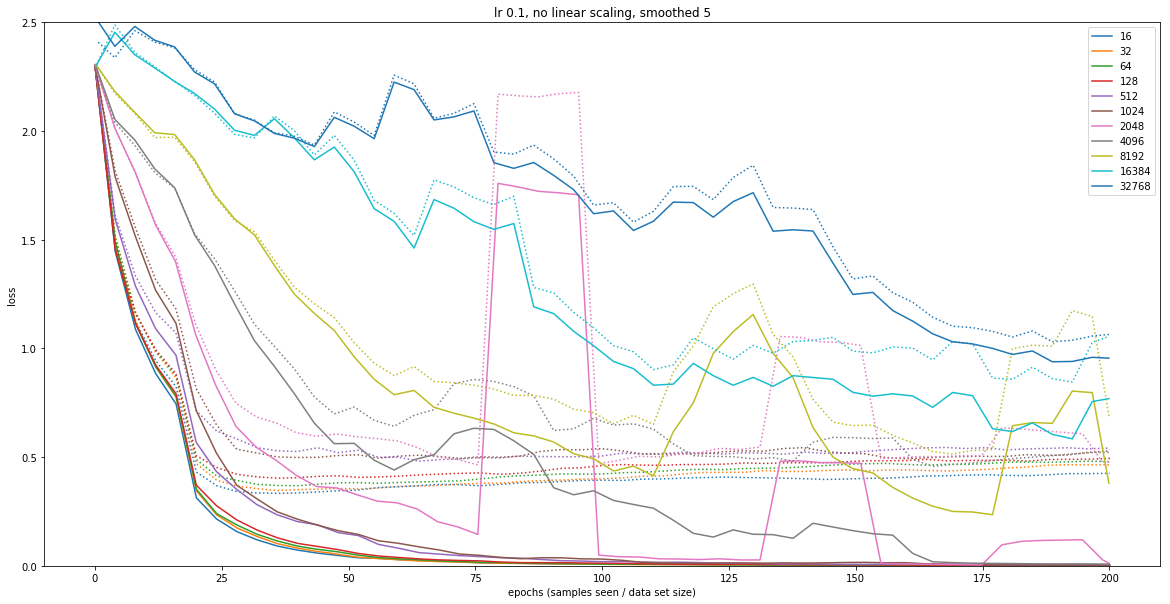

In [5]:
import itertools
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

smooth = 5
plt.figure(figsize=(20,10))
simple = simple_df(False)
for (_, row), c in zip(simple.iterrows(), colors):
    xs = row['idx'] * row['batch_size'] / (50000)
    simple = simple.sort_values('batch_size')
    train = ma(row['train_loss'], smooth)
    test = ma(row['test_loss'], smooth)
    plt.plot(xs, train, color=c, label=row['batch_size'])
    plt.plot(xs, test, color=c, ls=':')
plt.title('lr 0.1, no linear scaling, smoothed {}'.format(smooth))
plt.legend(loc='upper right')
plt.ylim(0, 2.5)
plt.xlabel('epochs (samples seen / data set size)')
plt.ylabel('loss')
plt.show()

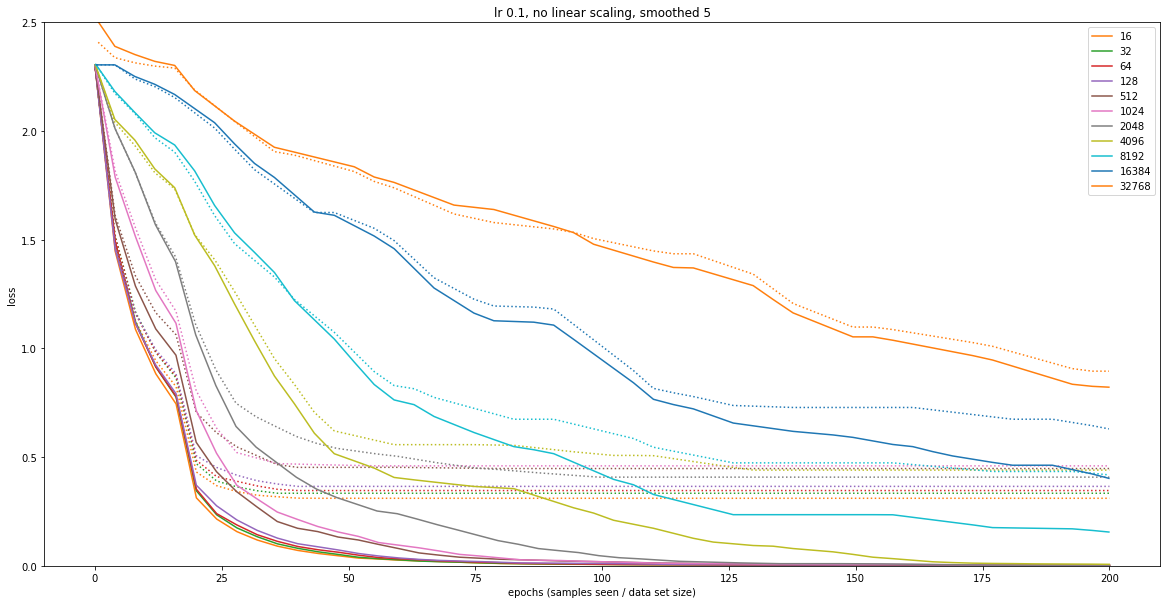

In [6]:
# montonic version of above
plt.figure(figsize=(20,10))
for (_, row), c in zip(simple.iterrows(), colors):
    xs = row['idx'] * row['batch_size'] /  50000
    train = ma(np.minimum.accumulate(row['train_loss']), smooth)
    test = ma(np.minimum.accumulate(row['test_loss']), smooth)
    plt.plot(xs, train, color=c, label=row['batch_size'])
    plt.plot(xs, test, color=c, ls=':')
plt.title('lr 0.1, no linear scaling, smoothed {}'.format(smooth))
plt.legend(loc='upper right')
plt.ylim(0, 2.5)
plt.xlabel('epochs (samples seen / data set size)')
plt.ylabel('loss')
plt.show()

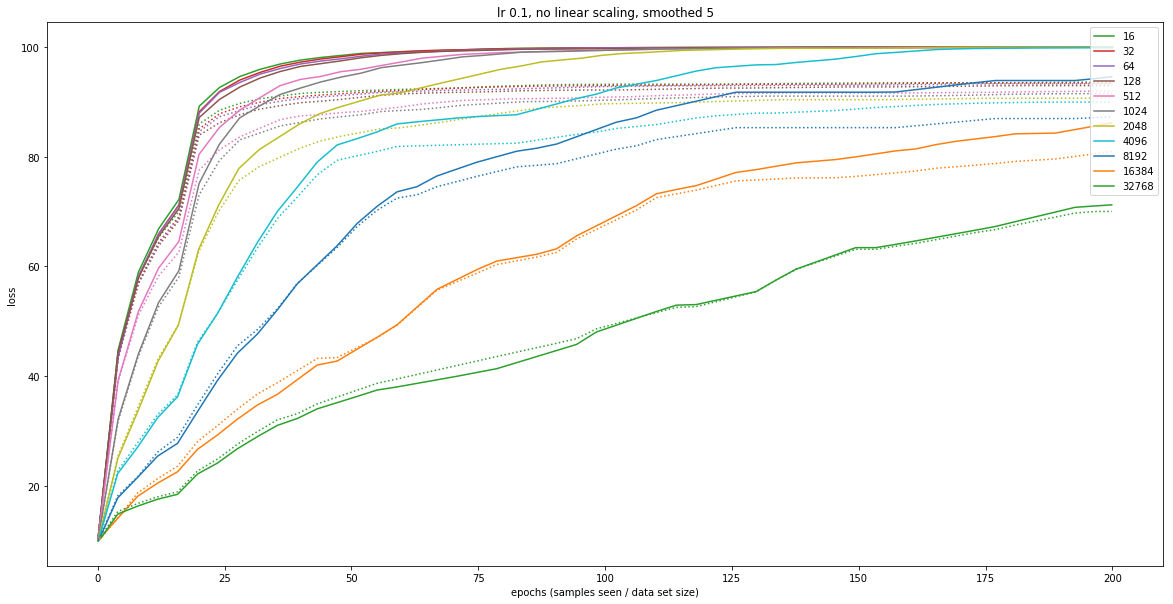

In [7]:
# montonic version of above
plt.figure(figsize=(20,10))
for (_, row), c in zip(simple.iterrows(), colors):
    xs = row['idx'] * row['batch_size'] /  50000
    train = ma(np.maximum.accumulate(row['train_accuracy']), smooth)
    test = ma(np.maximum.accumulate(row['test_accuracy']), smooth)
    plt.plot(xs, train, color=c, label=row['batch_size'])
    plt.plot(xs, test, color=c, ls=':')
plt.title('lr 0.1, no linear scaling, smoothed {}'.format(smooth))
plt.legend(loc='upper right')
#plt.ylim(0, 2.5)
plt.xlabel('epochs (samples seen / data set size)')
plt.ylabel('loss')
plt.show()

/home/vlad/dev/anaconda3/envs/lbs-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.


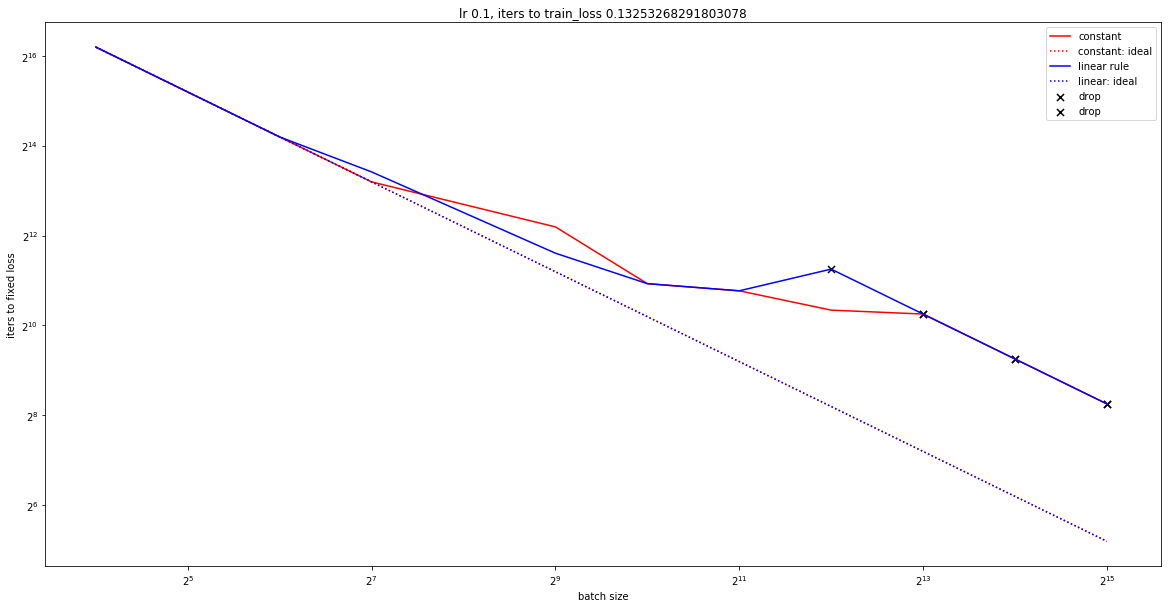

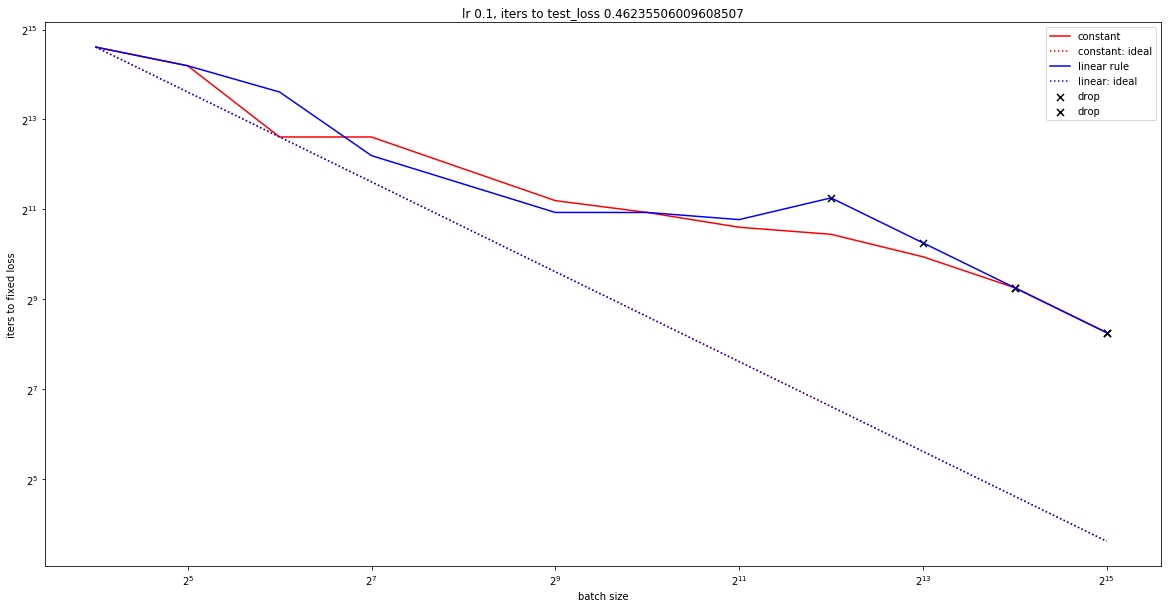

In [8]:
for loss in ['train_loss', 'test_loss']:
    # just made this 75% rule up
    losses_for_lr = df[loss].loc[df['learning_rate'] == lr]
    maximin = np.percentile(losses_for_lr.map(min), 75)
    
    loss_val = maximin
    baseline_bs = 16

    def iters_to_loss(row):
        dips = row[loss] <= loss_val
        first_dip = np.argmax(dips)
        if not dips.any():
            first_dip = -1        
        return pd.Series({'drop': row['idx'][first_dip], 'fail': first_dip < 0})
    
    drop_df_linear = simple_df(True)
    drop_df_const = simple_df(False)
    
    lr_df_linear = drop_df_linear.join(drop_df_linear.apply(iters_to_loss, axis=1))
    lr_df_const = drop_df_const.join(drop_df_const.apply(iters_to_loss, axis=1))
    
    plt.figure(figsize=(20,10))
    
    plt.loglog(lr_df_const['batch_size'], lr_df_const['drop'], color='r', label='constant', basex=2, basey=2)
    ix = lr_df_const.index[lr_df_const['batch_size'] == baseline_bs][0]
    baseline_its = lr_df_const['drop'].loc[ix]
    plt.loglog(lr_df_const['batch_size'], baseline_its * baseline_bs / lr_df_const['batch_size'],
               color='r', ls=':', label='constant: ideal', basex=2, basey=2)
    plt.loglog(lr_df_linear['batch_size'], lr_df_linear['drop'], color='b', label='linear rule',
               basex=2, basey=2)
    ix = lr_df_linear.index[lr_df_linear['batch_size'] == baseline_bs][0]
    baseline_its = lr_df_linear['drop'].loc[ix]
    plt.loglog(lr_df_linear['batch_size'], baseline_its * baseline_bs / lr_df_linear['batch_size'],
               color='b', ls=':', label='linear: ideal', basex=2, basey=2)
    
    # plot which examples failed to reach loss
    for ddf in [lr_df_linear, lr_df_const]:
        if ddf['fail'].any():
            plt.scatter(ddf['batch_size'][ddf['fail']], 
                ddf['drop'][ddf['fail']], marker='x', s=50, color='black')
    
    plt.title('lr {}, iters to {} {}'.format(lr, loss, loss_val))
    plt.legend(loc='upper right')
    plt.xlabel('batch size')
    plt.ylabel('iters to fixed loss')
    plt.show()

In [17]:
lr = 0.1
baseline_bs = 16

def contour_plot_lr(loss, monotonic, transform, transform_name, linear_lr=False, levels=None):

    lr_df = simple_df(linear_lr)
    
    if monotonic < 0:
        lr_df.loc[:, loss] = lr_df[loss].map(np.fmin.accumulate)
    if monotonic > 0:
        lr_df.loc[:, loss] = lr_df[loss].map(np.fmax.accumulate)

    def flatmap(df, func):
        # https://github.com/pandas-dev/pandas/issues/8517
        rows = []
        cols = df.columns
        for r in df.values:
            index = 0
            row = {}
            for col in cols:
                row[col] = r[index]
                index += 1
            multrows = func(row)
            for rr in multrows:
                rows.append(rr)
        return pd.DataFrame.from_records(rows)

    points = flatmap(lr_df, lambda r: [{'iter': r['idx'][i], 'loss': r[loss][i], 'bs': r['batch_size']}
                                 for i in range(len(r['idx']))])
    x = np.log2(points['bs'])
    y = np.log2(points['iter'])
    z = transform(points['loss'])
    if not levels:
        levels = np.unique(np.percentile(z, range(0, 100, 5)))
    plt.figure(figsize=tuple(map(lambda x: 3 * x, plt.figaspect(1.0))))
    tri = plt.tricontourf(x, y, z, levels=levels, cmap="RdBu_r")
    plt.colorbar(tri)
    plt.title('contour of {} at lr {}'.format(transform_name(loss), lr))
    plt.xlabel('log2 batch size')
    plt.ylabel('log2 iters')
    plt.show()

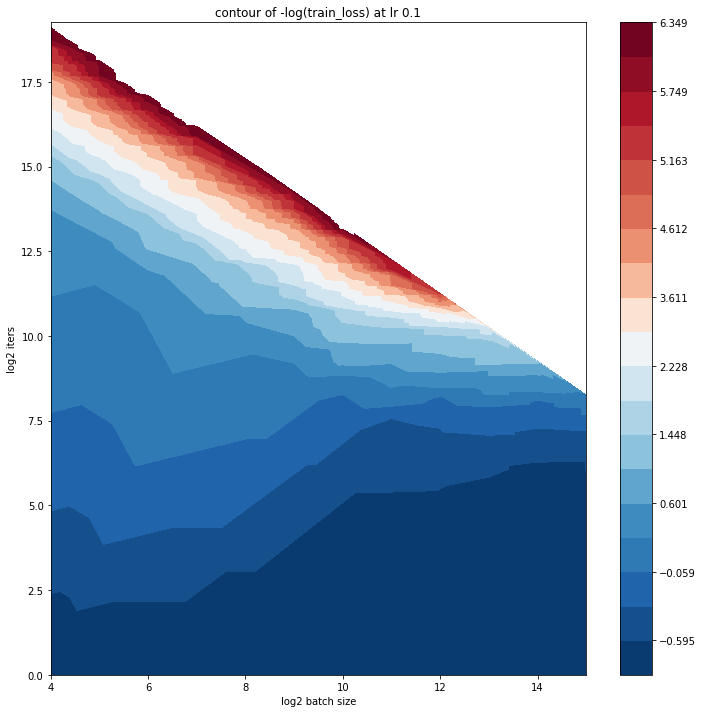

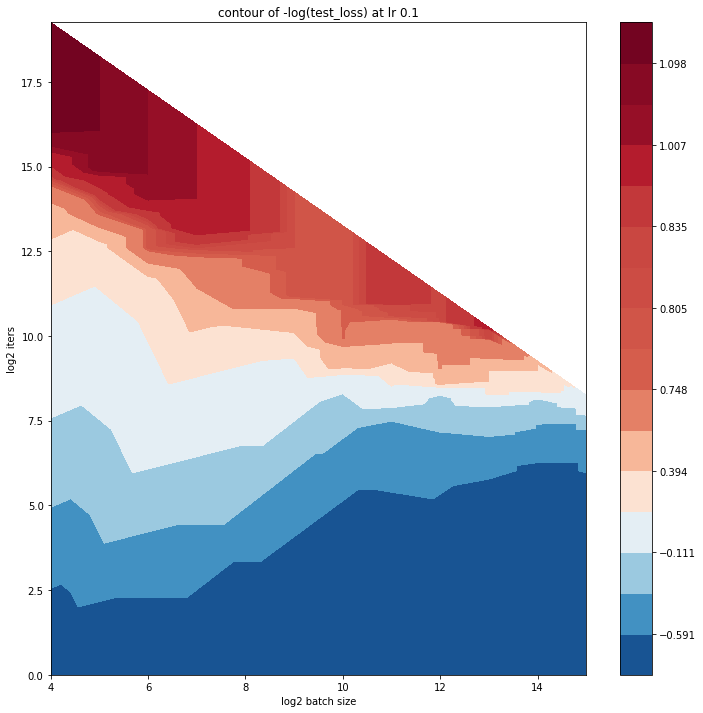

In [18]:
monotonic = -1
linear_lr = False
contour_plot_lr('train_loss', monotonic, lambda x: -np.log(x), '-log({})'.format, linear_lr)
contour_plot_lr('test_loss', monotonic, lambda x: -np.log(x), '-log({})'.format, linear_lr)

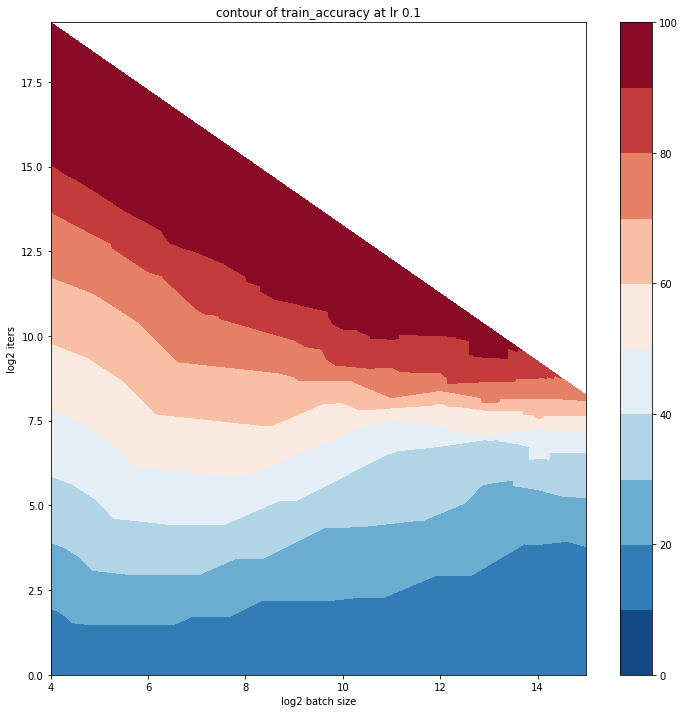

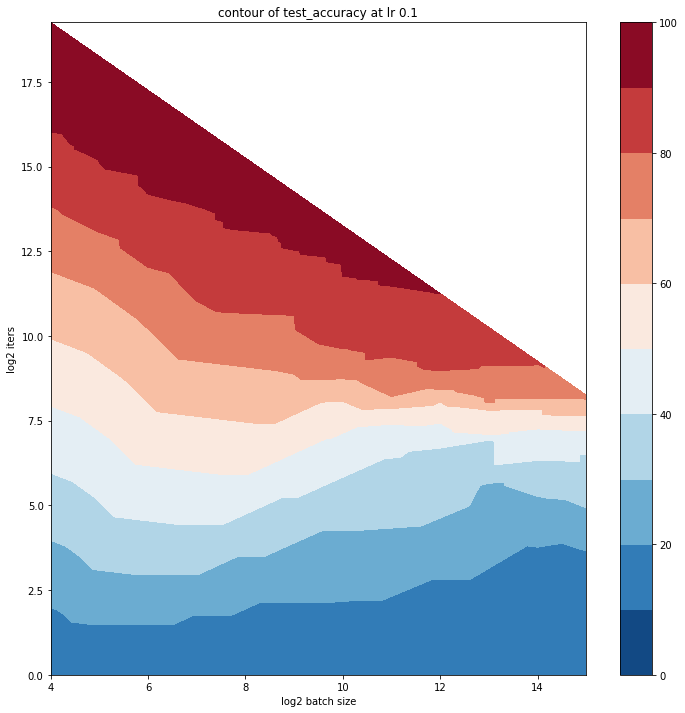

In [20]:
levels = range(0, 101, 10)
monotonic = 1
contour_plot_lr('train_accuracy', monotonic, lambda x: x, lambda x: x, linear_lr, levels)
contour_plot_lr('test_accuracy', monotonic, lambda x: x, lambda x: x, linear_lr, levels)

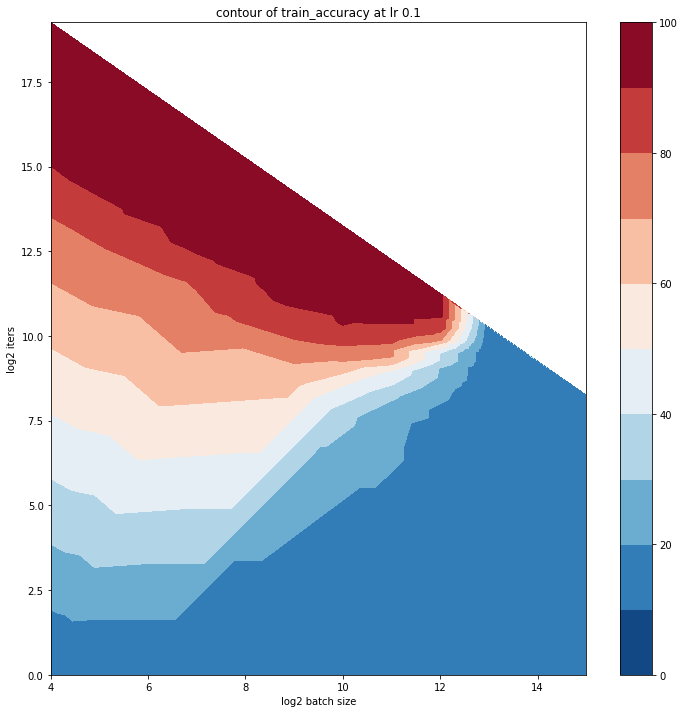

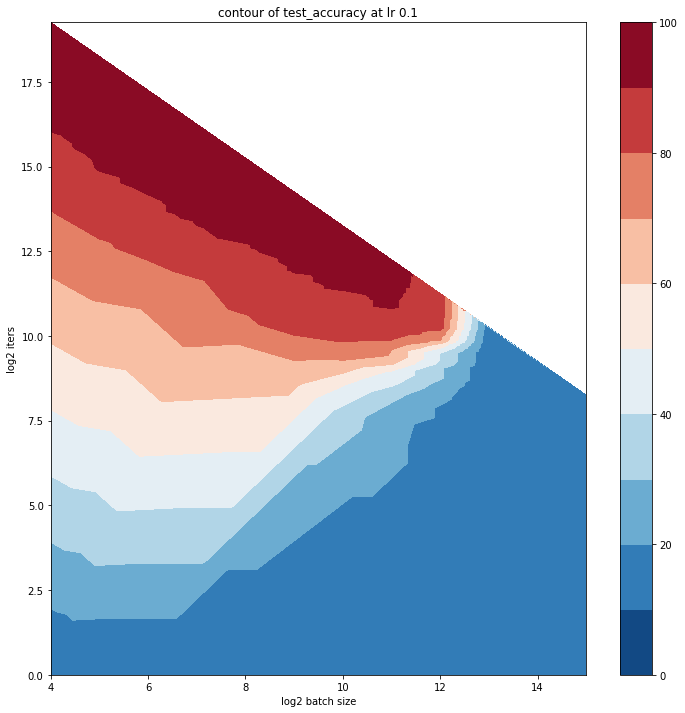

In [22]:
levels = range(0, 101, 10)
linear_lr = True
monotonic = 1
contour_plot_lr('train_accuracy', monotonic, lambda x: x, lambda x: x, linear_lr, levels)
contour_plot_lr('test_accuracy', monotonic, lambda x: x, lambda x: x, linear_lr, levels)

/home/vlad/dev/anaconda3/envs/lbs-env/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
/home/vlad/dev/anaconda3/envs/lbs-env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


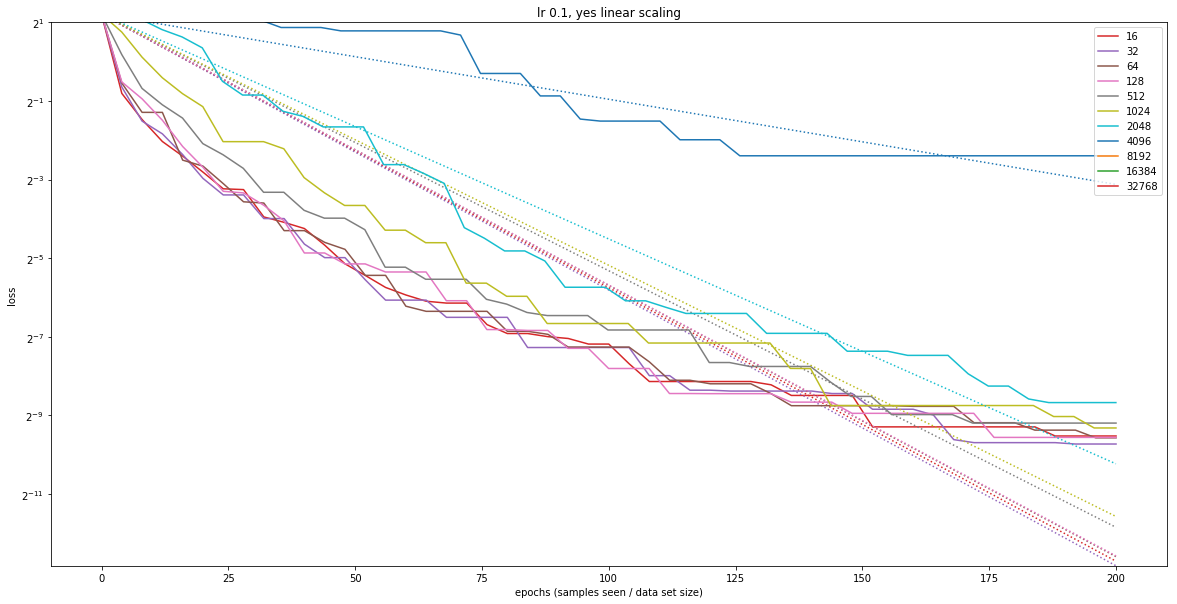

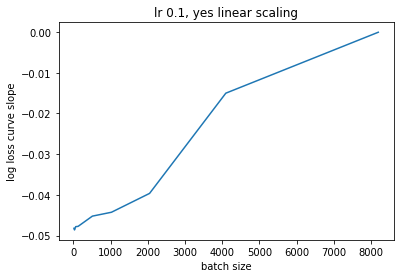

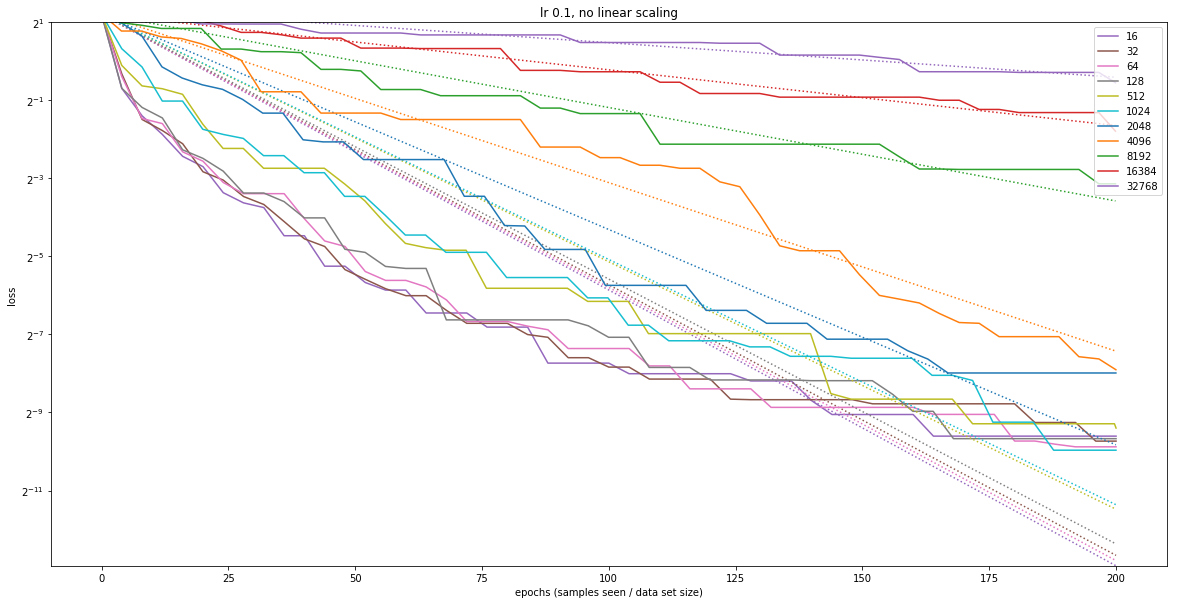

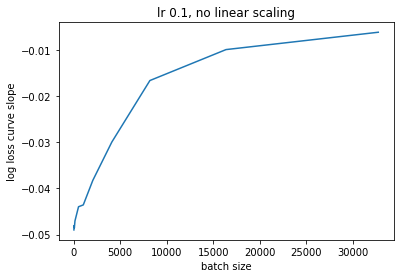

In [59]:
intercept = False
for linear_scaling in [True, False]:
    simple = simple_df(linear_scaling)
    
    slopes = []
    plt.figure(figsize=(20,10))
    for (_, row), c in zip(simple.iterrows(), colors):
        xs = row['idx'] * row['batch_size'] / 50000
        train = np.minimum.accumulate(row['train_loss'])
        plt.semilogy(xs, train, color=c, label=row['batch_size'], basey=2)
        
        logtrain = np.log(train)
        if intercept:
            coefs = np.vstack([xs, np.ones(len(xs))]).T
            slope, intercept = np.linalg.lstsq(coefs, logtrain)[0]
            fit = np.exp(intercept + slope * xs)
        else:
            coefs = np.vstack([xs - xs[0]]).T
            slope = np.linalg.lstsq(coefs, logtrain - logtrain[0])[0]
            slope = slope[0]
            fit = np.exp(slope * (xs - xs[0]) + logtrain[0])
        plt.semilogy(xs, fit, color=c, ls=':', basey=2)
        
        slopes.append((row['batch_size'], slope))
    plt.title('lr 0.1, {} linear scaling'.format(
        'yes' if linear_scaling else 'no'))
    plt.legend(loc='upper right')
    plt.ylim(0, 2)
    plt.xlabel('epochs (samples seen / data set size)')
    plt.ylabel('loss')
    plt.show()
    
    bs, slopes = zip(*slopes)
    plt.plot(bs, slopes)
    plt.title('lr 0.1, {} linear scaling'.format(
        'yes' if linear_scaling else 'no'))
    plt.xlabel('batch size')
    plt.ylabel('log loss curve slope')